In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

In [4]:
data = pd.read_csv('FastagFraudDetection.csv')
data['FastagID'].fillna('Missing', inplace=True)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

<ipython-input-4-060384e6b408>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['FastagID'].fillna('Missing', inplace=True)


In [5]:
data['Hour_of_Day'] = data['Timestamp'].dt.hour
data[['Latitude', 'Longitude']] = data['Geographical_Location'].str.split(',', expand=True).astype(float)
data.drop(['Geographical_Location'], axis=1, inplace=True)

In [6]:
categorical_cols = ['Vehicle_Type', 'TollBoothID', 'Lane_Type', 'Vehicle_Dimensions', 'Vehicle_Plate_Number', 'FastagID']
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])
data['Fraud_indicator'] = LabelEncoder().fit_transform(data['Fraud_indicator'])

In [7]:
X = data.drop(['Fraud_indicator', 'Transaction_ID', 'Timestamp'], axis=1)
y = data['Fraud_indicator']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
svm_model = SVC(probability=True).fit(X_train_scaled, y_train)
svm_score = svm_model.score(X_test_scaled, y_test)
knn_model = KNeighborsClassifier().fit(X_train_scaled, y_train)
knn_score = knn_model.score(X_test_scaled, y_test)
logistic_model = LogisticRegression().fit(X_train_scaled, y_train)
logistic_score = logistic_model.score(X_test_scaled, y_test)
kmeans_model = KMeans(n_clusters=2).fit(X_train_scaled)
# Note: K-Means is not typically used for supervised learning but included for demonstration.
print("SVM Accuracy:", svm_score)
print("KNN Accuracy:", knn_score)
print("Logistic Regression Accuracy:", logistic_score)

SVM Accuracy: 0.943
KNN Accuracy: 0.867
Logistic Regression Accuracy: 0.966


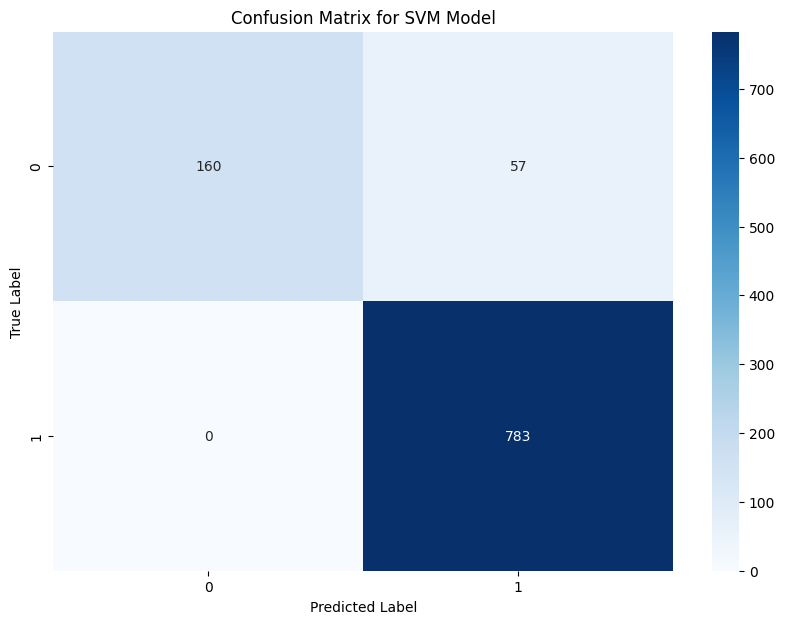

In [9]:
svm_predictions = svm_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

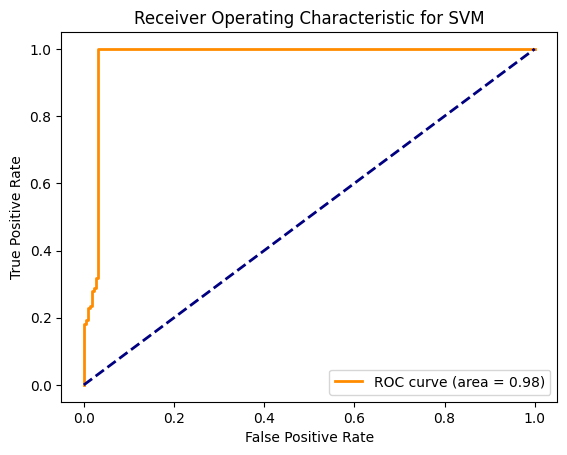

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, svm_model.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM')
plt.legend(loc="lower right")
plt.show()

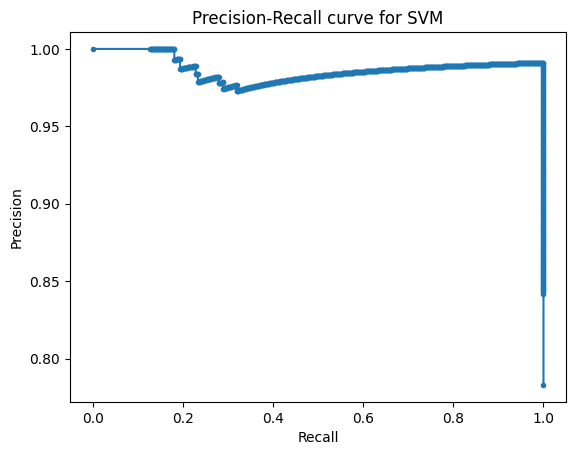

In [11]:
precision, recall, _ = precision_recall_curve(y_test, svm_model.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall curve for SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [12]:
map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
fraud_map = folium.Map(location=map_center, zoom_start=12)
fraud_data = data[data['Fraud_indicator'] == 1]
for idx, row in fraud_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color='red',
        fill=True,
        fill_opacity=0.6,
        tooltip=f"Fraud at {row['TollBoothID']}"
    ).add_to(fraud_map)
fraud_map.save('fraud_locations.html')

In [13]:
location_fraud_count = data.groupby(['Latitude', 'Longitude'])['Fraud_indicator'].sum().reset_index()
location_fraud_count.rename(columns={'Fraud_indicator': 'Fraud_Count'}, inplace=True)
location_fraud_count['Total_Transactions'] = data.groupby(['Latitude', 'Longitude'])['Fraud_indicator'].count().values
location_fraud_count['Fraud_Rate'] = location_fraud_count['Fraud_Count'] / location_fraud_count['Total_Transactions']

# Now create the enhanced map
map_enhanced = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()], zoom_start=12)

# Loop through the location_fraud_count DataFrame instead of fraud_data to ensure we have the Fraud_Rate
for _, row in location_fraud_count.iterrows():
    # Define the color based on fraud rate
    color = 'red' if row['Fraud_Rate'] > 0.1 else 'orange'
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=10,  # Larger radius for emphasis
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=f"Fraud Rate: {row['Fraud_Rate']*100:.2f}%"
    ).add_to(map_enhanced)

map_enhanced.save('enhanced_fraud_locations.html')

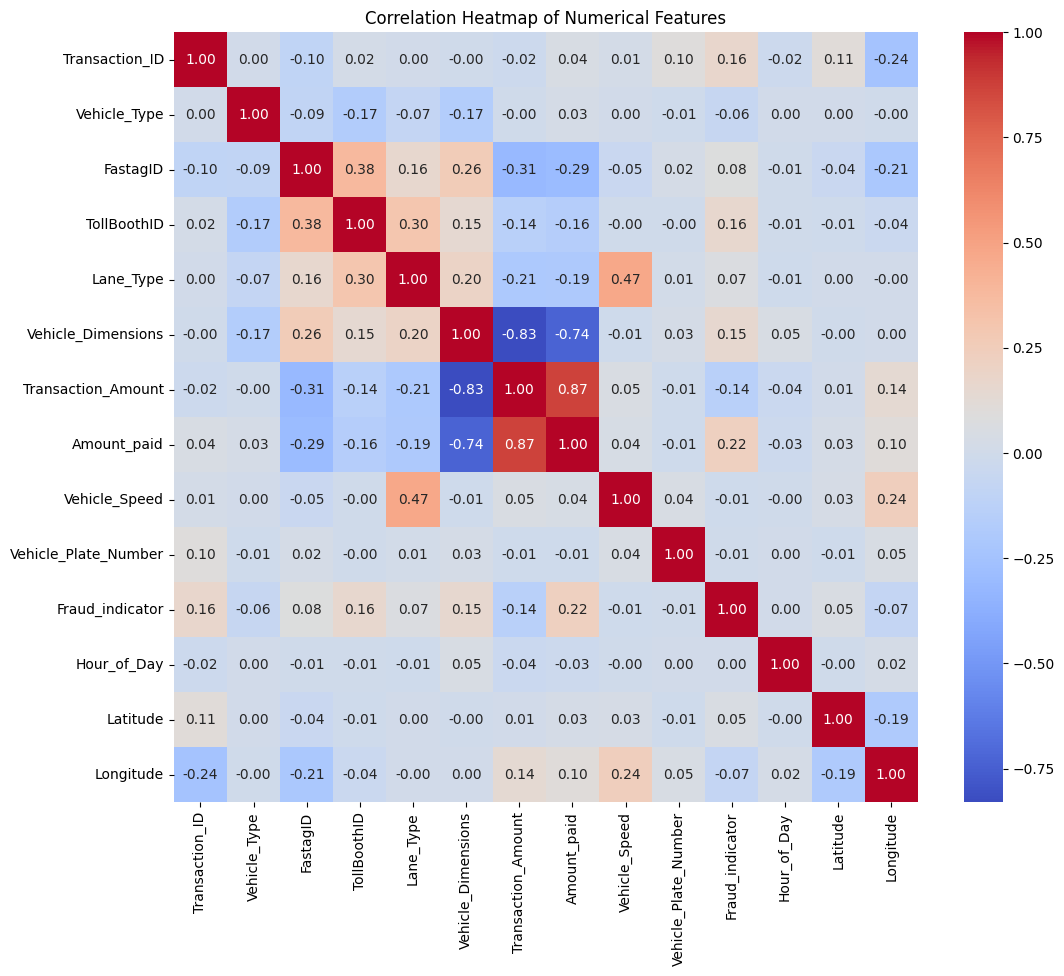

In [14]:
corr = data.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

<ipython-input-15-c77a05eea677>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.set_index('Timestamp').resample('M')['Transaction_ID'].count().plot()


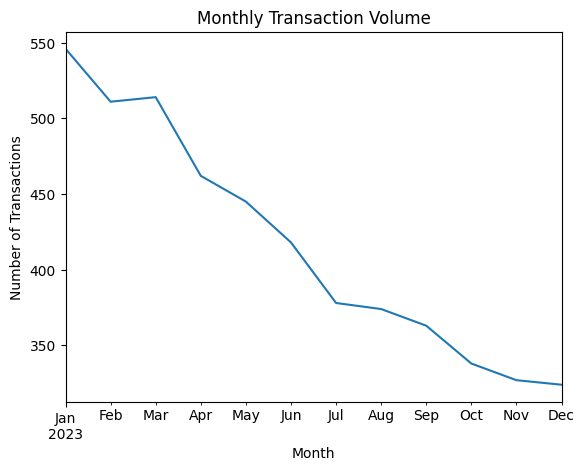

In [15]:
data.set_index('Timestamp').resample('M')['Transaction_ID'].count().plot()
plt.title('Monthly Transaction Volume')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

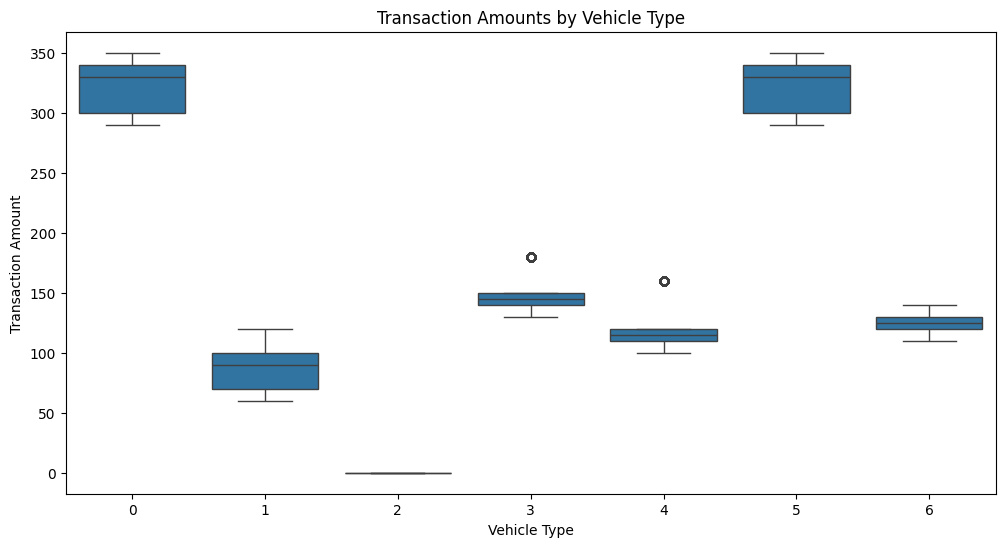

In [16]:
# Check if the necessary columns exist in the DataFrame
required_columns = ['Vehicle_Type', 'Transaction_Amount']
missing_columns = [col for col in required_columns if col not in data.columns]
if not missing_columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Vehicle_Type', y='Transaction_Amount', data=data)
    plt.title('Transaction Amounts by Vehicle Type')
    plt.xlabel('Vehicle Type')
    plt.ylabel('Transaction Amount')
    plt.show()
else:
    print("The following required columns are missing from the DataFrame:", missing_columns)


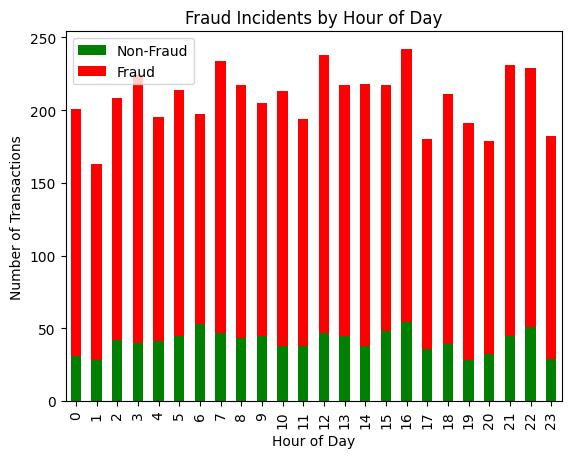

In [17]:
pd.crosstab(data['Hour_of_Day'], data['Fraud_indicator']).plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Fraud Incidents by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.legend(['Non-Fraud', 'Fraud'], loc='upper left')
plt.show()

In [18]:
location_fraud_count = data.groupby(['Latitude', 'Longitude'])['Fraud_indicator'].sum().reset_index()
location_fraud_count.rename(columns={'Fraud_indicator': 'Fraud_Count'}, inplace=True)
location_fraud_count['Total_Transactions'] = data.groupby(['Latitude', 'Longitude'])['Fraud_indicator'].count().values
location_fraud_count['Fraud_Rate'] = location_fraud_count['Fraud_Count'] / location_fraud_count['Total_Transactions']
high_fraud_locations = location_fraud_count[location_fraud_count['Fraud_Rate'] > 0.1]
data['High_Risk_Area'] = data.apply(
    lambda row: (row['Latitude'], row['Longitude']) in list(zip(high_fraud_locations['Latitude'], high_fraud_locations['Longitude'])),
    axis=1
)

In [19]:
print("\nDetailed Statistics of High Risk Areas:")
print(location_fraud_count)

# Filter and display only those locations where the fraud rate exceeds a specified threshold, indicating high risk.
high_risk_threshold = 0.1  # Threshold can be adjusted based on requirement
high_risk_areas = location_fraud_count[location_fraud_count['Fraud_Rate'] > high_risk_threshold]
print(f"\nLocations with a Fraud Rate greater than {high_risk_threshold}:")
print(high_risk_areas)

# Print additional details if needed
if not high_risk_areas.empty:
    print("\nHigh Risk Area Details:")
    for index, row in high_risk_areas.iterrows():
        print(f"Location (Latitude: {row['Latitude']}, Longitude: {row['Longitude']}) has a fraud count of {row['Fraud_Count']} out of {row['Total_Transactions']} transactions, resulting in a fraud rate of {row['Fraud_Rate']:.2f}.")
else:
    print("\nNo high-risk areas detected above the threshold.")


Detailed Statistics of High Risk Areas:
    Latitude  Longitude  Fraud_Count  Total_Transactions  Fraud_Rate
0  12.841977  77.675475          769                1000       0.769
1  12.936687  77.531140          832                1000       0.832
2  13.042661  77.475801          801                1000       0.801
3  13.059816  77.770687          754                1000       0.754
4  13.213316  77.554135          861                1000       0.861

Locations with a Fraud Rate greater than 0.1:
    Latitude  Longitude  Fraud_Count  Total_Transactions  Fraud_Rate
0  12.841977  77.675475          769                1000       0.769
1  12.936687  77.531140          832                1000       0.832
2  13.042661  77.475801          801                1000       0.801
3  13.059816  77.770687          754                1000       0.754
4  13.213316  77.554135          861                1000       0.861

High Risk Area Details:
Location (Latitude: 12.84197701525119, Longitude: 77.675475

In [20]:
print("\nConclusion:")
print("The analysis has identified specific geographic locations with high fraud rates. These areas should be targeted with enhanced security measures and closer monitoring to mitigate fraud risks.")

print("\nNext Steps:")
print("1. Implement targeted fraud prevention strategies in high-risk areas.")
print("2. Regularly update and re-analyze the data to monitor the effectiveness of implemented measures.")
print("3. Explore additional data features that could further refine fraud detection accuracy.")
print("4. Consider deploying real-time fraud detection systems at identified high-risk locations.")


Conclusion:
The analysis has identified specific geographic locations with high fraud rates. These areas should be targeted with enhanced security measures and closer monitoring to mitigate fraud risks.

Next Steps:
1. Implement targeted fraud prevention strategies in high-risk areas.
2. Regularly update and re-analyze the data to monitor the effectiveness of implemented measures.
3. Explore additional data features that could further refine fraud detection accuracy.
4. Consider deploying real-time fraud detection systems at identified high-risk locations.
